In [13]:
import time
import smtplib
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

plt.style.use('seaborn')

In [158]:
days = 500
quotes = [
    {'code': 'comex.GC', 'market': '24', 'em': '18953'}
]
data = pd.DataFrame()

edate = datetime.now()
delta = timedelta(days=days)
sdate = edate - delta

e1 = edate.strftime('%d.%m.%Y')
s1 = sdate.strftime('%d.%m.%Y')

e2 = edate.strftime('%y.%m.%d')
s2 = sdate.strftime('%y.%m.%d')

edate = datetime.timetuple(edate)
sdate = datetime.timetuple(sdate)
ey, em, ed = edate[:3]
sy, sm, sd = sdate[:3]

def draw_candle(candle):
    x = candle.index[0]
    o = candle.values[0][0]
    h = candle.values[0][1]
    l = candle.values[0][2]
    c = candle.values[0][3]
    color = 'green' if o <= c else 'red'
    plt.plot([x, x], [h, l], color=color, linewidth=1)
    plt.plot([x, x], [o, c], color=color, linewidth=6)
    plt.xticks(rotation='vertical')
    
def draw_hist(candle):
    x = candle.index[0]
    h = candle.values[0][9]
    color = '#88ff88' if h >= 0 else '#ff8888'
    plt.plot([x, x], [0, h], color=color, linewidth=6)
    plt.xticks(rotation='vertical')

def ema(arr):
    a = 2 / (arr.size + 1)
    return arr[-1] * a + arr[-2] * (1 - a)

def get_url(code, s1, e1, sd, sm, sy, s2, ed, em, ey, e2, market, e):
    sd, sm, sy, ed, em, ey = str(sd), str(sm-1), str(sy), str(ed), str(em-1), str(ey) 
    return ('http://export.finam.ru/{0}_{1}_{2}.csv?market={11}&em={12}&code={0}&apply=0&df={3}&mf={4}&yf={5}&' +\
           'from={6}&dt={7}&mt={8}&yt={9}&to={10}&p=8&f={0}_{1}_{2}&e=.csv&cn={0}&dtf=1&tmf=1&MSOR=1&mstime=on&' +\
           'mstimever=1&sep=3&sep2=1&datf=5&at=1').format(code, s1, e1, sd, sm, sy, s2, ed, em, ey, e2, market, e)

def make_dataset(url):
    try:
        data = pd.read_csv(url, parse_dates={'date': [0]}, index_col=0, sep=';')
    except:
        print('Reading from URL failed')
    
    data.rename(lambda x: str.lower(x[1:-1]), axis='columns', inplace=True)
    data.drop(columns=['time'], inplace=True)
    
    data['fast'] = data.close.ewm(span=12).mean()
    data['slow'] = data.close.ewm(span=26).mean()
    data['macd'] = data.fast - data.slow
    data['signal'] = data.macd.ewm(span=9).mean()
    data['hist'] = data.macd - data.signal
    return data



In [159]:
code, market, e = quotes[0]['code'], quotes[0]['market'], quotes[0]['em']
url = get_url(code, s1, e1, sd, sm, sy, s2, ed, em, ey, e2, market, e)
data = make_dataset(url)

In [160]:
data.head()

,open,high,low,close,vol,fast,slow,macd,signal,hist
date,,,,,,,,,,
2018-05-09,1311.3,1317.8,1304.2,1315.4,325222,1315.400000,1315.400000,0.000000,0.000000,0.000000
2018-05-10,1315.4,1323.4,1310.6,1319.8,320759,1317.783333,1317.684615,0.098718,0.054843,0.043875
2018-05-11,1319.8,1326.3,1317.0,1318.4,203342,1318.024018,1317.941646,0.082372,0.066126,0.016247
2018-05-13,1318.3,1322.4,1317.9,1319.3,30234,1318.426796,1318.321383,0.105413,0.079435,0.025979
2018-05-14,1319.3,1321.9,1310.9,1311.1,213483,1316.436132,1316.646714,-0.210582,-0.006839,-0.203743


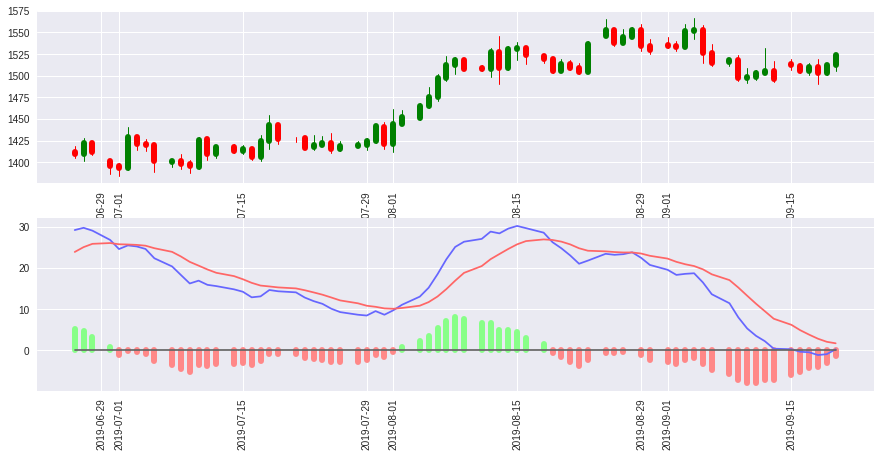

In [161]:
start, end = data.shape[0]-75, data.shape[0]

fig = plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
for i in range(start, end):
    draw_candle(data[i:i+1])

plt.subplot(2, 1, 2)
for i in range(start, end):
    draw_hist(data[i:i+1])
plt.plot(data.index[start:end], data.macd[start:end], color='#6666ff')
plt.plot(data.index[start:end], data.signal[start:end], color='#ff6666') 
plt.plot(data.index[start:end], np.zeros(end-start), color='#666666')



In [162]:
data[-70:]

,open,high,low,close,vol,fast,slow,macd,signal,hist
date,,,,,,,,,,
2019-07-02,1393.4,1441.0,1391.6,1429.8,425317,1401.082403,1375.622518,25.459885,25.684395,-0.224509
2019-07-03,1429.8,1431.6,1414.7,1421.6,299489,1404.238957,1379.028258,25.210699,25.589656,-0.378956
2019-07-04,1421.6,1426.8,1412.7,1420.0,126360,1406.663733,1382.063202,24.600531,25.391831,-0.791300
2019-07-05,1420.0,1420.8,1388.6,1401.2,375806,1405.823158,1383.480742,22.342416,24.781948,-2.439532
2019-07-07,1401.0,1404.0,1395.0,1401.8,41672,1405.204211,1384.837724,20.366487,23.898856,-3.532369
2019-07-08,1401.8,1409.9,1392.7,1398.1,254883,1404.111255,1385.820115,18.291140,22.777313,-4.486172
2019-07-09,1398.1,1402.4,1387.5,1395.3,246719,1402.755678,1386.522329,16.233349,21.468520,-5.235171
2019-07-10,1395.2,1429.4,1391.8,1426.4,420392,1406.393266,1389.476230,16.917035,20.558223,-3.641188
2019-07-11,1426.5,1427.1,1402.7,1409.4,307044,1406.855840,1390.952065,15.903775,19.627333,-3.723558
